In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load datasets
customers = pd.read_csv(r"C:\Users\brnan\Downloads\Customers.csv")
products = pd.read_csv(r"C:\Users\brnan\Downloads\Products.csv")
transactions = pd.read_csv(r"C:\Users\brnan\Downloads\Transactions.csv")

In [7]:
# Display dataset shapes
print(f"Customers: {customers.shape}")
print(f"Products: {products.shape}")
print(f"Transactions: {transactions.shape}")

Customers: (200, 4)
Products: (100, 4)
Transactions: (1000, 7)


In [5]:
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [11]:
print(f"Merged Data: {merged_data.shape}")

Merged Data: (1000, 13)


In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


In [13]:
#for merging 'price x' and 'price y'
merged_data['Price'] = merged_data['Price_x'].combine_first(merged_data['Price_y'])
merged_data= merged_data.drop(['Price_x', 'Price_y'], axis=1)

In [16]:
print(print(f"Merged Data: {merged_data.shape}"))
print(merged_data.info())

Merged Data: (1000, 12)
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   CustomerName     1000 non-null   object 
 7   Region           1000 non-null   object 
 8   SignupDate       1000 non-null   object 
 9   ProductName      1000 non-null   object 
 10  Category         1000 non-null   object 
 11  Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 93.9+ KB
None


# data clustering

In [19]:
# Aggregate features for clustering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Total spending
    'Quantity': 'sum',            # Total quantity purchased
    'TransactionID': 'count'      # Number of transactions
}).rename(columns={'TotalValue': 'TotalSpending', 'TransactionID': 'NumTransactions'}).reset_index()

print(customer_features.head())

  CustomerID  TotalSpending  Quantity  NumTransactions
0      C0001        3354.52        12                5
1      C0002        1862.74        10                4
2      C0003        2725.38        14                4
3      C0004        5354.88        23                8
4      C0005        2034.24         7                3


* standardize the data

In [20]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpending', 'Quantity', 'NumTransactions']])

# Convert to DataFrame for visualization
scaled_df = pd.DataFrame(scaled_features, columns=['TotalSpending', 'Quantity', 'NumTransactions'])
print(scaled_df.head())


   TotalSpending  Quantity  NumTransactions
0      -0.061701 -0.122033        -0.011458
1      -0.877744 -0.448000        -0.467494
2      -0.405857  0.203934        -0.467494
3       1.032547  1.670787         1.356650
4      -0.783929 -0.936951        -0.923530


# clustering

C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

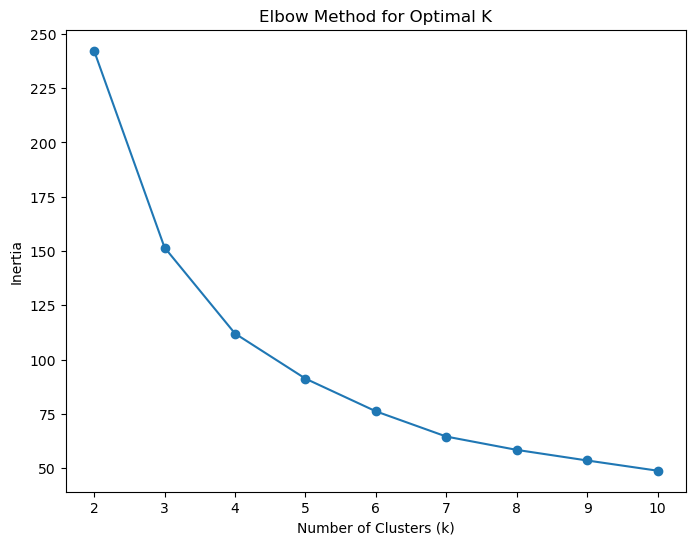

In [21]:
# Determine optimal number of clusters using Elbow Method
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


* Appling k-means clustering

In [23]:
# Fit K-Means with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

print(customer_features.head())


C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  CustomerID  TotalSpending  Quantity  NumTransactions  Cluster
0      C0001        3354.52        12                5        2
1      C0002        1862.74        10                4        1
2      C0003        2725.38        14                4        2
3      C0004        5354.88        23                8        0
4      C0005        2034.24         7                3        1


* EVALUTION

In [24]:
# Calculate clustering metrics
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
silhouette = silhouette_score(scaled_features, customer_features['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")



Davies-Bouldin Index: 0.7685569688730743
Silhouette Score: 0.4148217825177174


# visualization of clusters

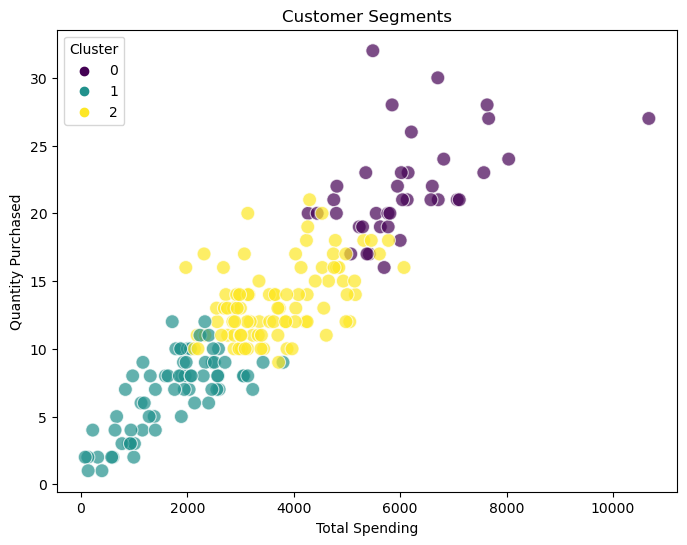

In [25]:
# Visualize clusters using TotalSpending and Quantity
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=customer_features,
    x='TotalSpending', y='Quantity', hue='Cluster',
    palette='viridis', s=100, alpha=0.7
)
plt.title('Customer Segments')
plt.xlabel('Total Spending')
plt.ylabel('Quantity Purchased')
plt.legend(title='Cluster')
plt.show()


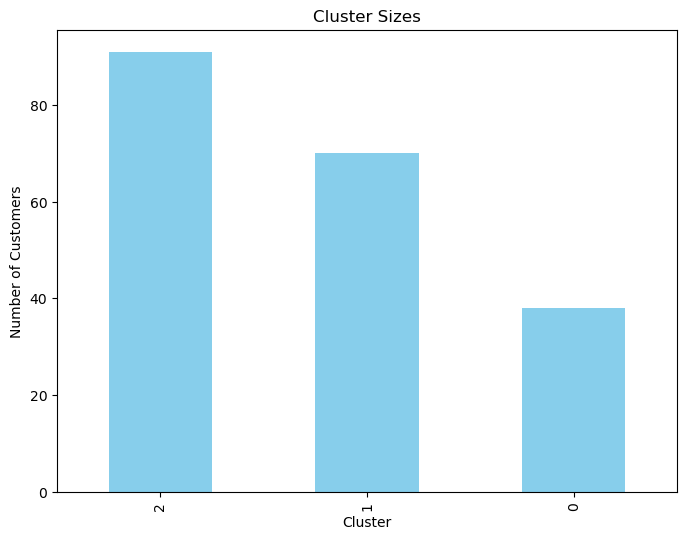

In [26]:
# Plot cluster sizes
cluster_sizes = customer_features['Cluster'].value_counts()
cluster_sizes.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


In [28]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas


In [27]:
# Create PDF report
def export_clustering_report(output_path, db_index, silhouette, optimal_k):
    c = canvas.Canvas(output_path, pagesize=letter)
    c.setFont("Helvetica", 12)
    c.drawString(50, 750, "Customer Segmentation Report")
    c.line(50, 745, 550, 745)
    c.drawString(50, 720, f"1. Optimal Number of Clusters: {optimal_k}")
    c.drawString(50, 700, f"2. Davies-Bouldin Index: {db_index:.4f}")
    c.drawString(50, 680, f"3. Silhouette Score: {silhouette:.4f}")
    c.drawString(50, 660, f"4. Cluster Sizes: {cluster_sizes.to_dict()}")
    c.drawString(50, 640, "5. Visualizations: Check generated scatter plots and bar charts.")
    c.save()

# Export report
export_clustering_report("Clustering_Report.pdf", db_index, silhouette, optimal_k)
print("PDF report generated: Clustering_Report.pdf")


PDF report generated: Clustering_Report.pdf
